In [26]:
import sys
sys.path.append("/tf/ProjectGabriel/pilca")

In [27]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from lightcurve_fitting import models, filters, lightcurve
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib



from utils.utils import load_lc
from utils.utils import light_curve_plot
import torch
import utils.torchphysics as tp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
torch.set_default_dtype(torch.float64)


# Building Fake Light Curve

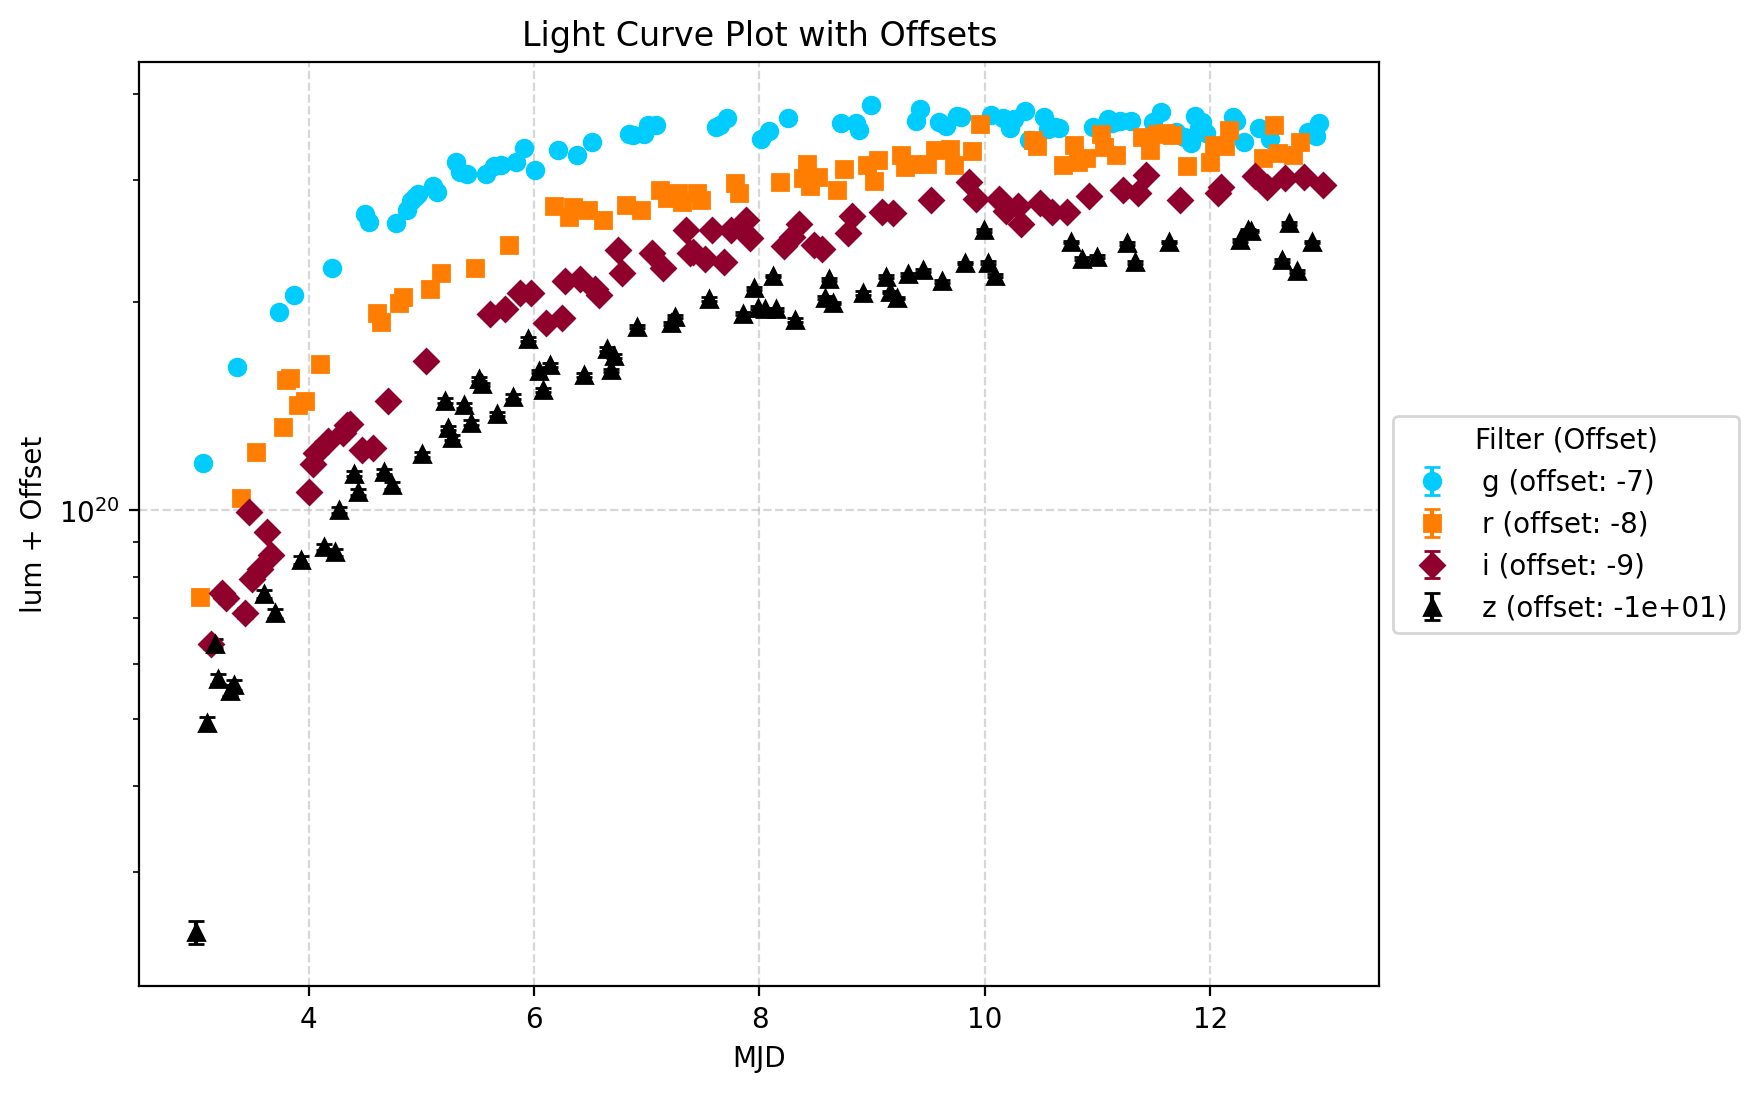

In [29]:
importlib.reload(models)
lc_fake = load_lc(fake=True)
model = models.ShockCooling4(lc_fake)


MJD = np.linspace(3, 13, 300)
filters_list = [filters.filtdict["g"], filters.filtdict["r"], filters.filtdict["i"], filters.filtdict["z"]]
filter_for_mjd = np.random.choice(filters_list, size=len(MJD), replace=True)

ten13cmtoRsol = 1e13*1.4374e-11
ten8p5cmstoten3kms = 10**.5
units_array = np.array([ten8p5cmstoten3kms, 1, ten13cmtoRsol, 1])
# model_inputs = np.array([7.2, 5, 1.6, 410, 2.5])/units_array
model_inputs = np.array([4, 2, 580, 2.5])/units_array

v_s = model_inputs[0]       # Shock velocity
M_env = model_inputs[1]     # Envelope mass
f_rho_M = model_inputs[1]   # Density profile factor
R = model_inputs[2]         # Radius
t_exp = model_inputs[3]     # explosion time
lum = model(MJD, v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=filter_for_mjd) + np.random.normal(0, 1e19, len(MJD))

lc = load_lc(lc=lightcurve.LC({"MJD":MJD,
                "lum":lum,
                "dlum":np.random.normal(.1e19, .1e18, len(lum)),
                "filter":filter_for_mjd}),
                fake=False)
lc
light_curve_plot(lc, offset = 1)
# aa

# Preparing PILCA

In [30]:
MJD_TO_MODEL = MJD
LUM_TO_MODEL = np.log10(lc["lum"])
DLUM_TO_MODEL = lc["dlum"]/lc["lum"]/np.log(10)

X_DATA = np.hstack([MJD_TO_MODEL.reshape(-1,1), LUM_TO_MODEL.reshape(-1,1), DLUM_TO_MODEL.reshape(-1,1)])
ufilters = np.unique(lc["filter"])
filters_mask = torch.zeros((len(ufilters),len(lc)), requires_grad=False, dtype=torch.bool)
for i in range(len(ufilters)):
    filters_mask[i] = torch.tensor(lc["filter"]==ufilters[i])

X_DATA = torch.tensor(X_DATA, requires_grad=False)

In [31]:
filters_mask[0]

tensor([False, False,  True, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False,  True, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False,  True,  True, False, False, False,
        False, False, False,  True, False, False,  True,  True,  True,  True,
        False, False, False,  True,  True, False, False, False, False,  True,
         True, False,  True, False, False, False, False,  True, False,  True,
        False,  True, False, False, False,  True, False,  True, False, False,
         True, False, False, False, False, False,  True, False, False, False,
        False,  True, False, False, False,  True, False, False, False, False,
        False, False, False, False, False,  True,  True, False, False,  True,
         True, False,  True, False, False, False, False, False, 

In [32]:
importlib.reload(models)
lc_fake = load_lc(fake=True)
model_original = models.ShockCooling4(lc_fake)

ten13cmtoRsol = 1e13*1.4374e-11

ten8p5cmstoten3kms = 10**.5
units_array = np.array([ten8p5cmstoten3kms, 1, ten13cmtoRsol, 1])
# model_inputs = #np.array([5.3875e+00, 4.1513e-07, 2.6636e+00, 1.7901e+00, 8.9253e-01])
v_s = model_inputs[0]       # Shock velocity
M_env = model_inputs[1]     # Envelope mass
f_rho_M = model_inputs[1]   # Density profile factor
R = model_inputs[2]         # Radius
t_exp = model_inputs[3]     # explosion time

lum = model_original(MJD[0:], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=[filter_for_mjd[0]])
lum_original = lum
lum[:20]

array([[3.79198994e+19, 3.97398076e+19, 4.15462756e+19, 4.33390794e+19,
        4.51180636e+19, 4.68831278e+19, 4.86342157e+19, 5.03713066e+19,
        5.20944086e+19, 5.38035533e+19, 5.54987916e+19, 5.71801900e+19,
        5.88478276e+19, 6.05017940e+19, 6.21421873e+19, 6.37691124e+19,
        6.53826796e+19, 6.69830037e+19, 6.85702029e+19, 7.01443979e+19,
        7.17057116e+19, 7.32542682e+19, 7.47901928e+19, 7.63136111e+19,
        7.78246489e+19, 7.93234321e+19, 8.08100860e+19, 8.22847357e+19,
        8.37475053e+19, 8.51985182e+19, 8.66378968e+19, 8.80657625e+19,
        8.94822355e+19, 9.08874346e+19, 9.22814776e+19, 9.36644808e+19,
        9.50365592e+19, 9.63978265e+19, 9.77483947e+19, 9.90883748e+19,
        1.00417876e+20, 1.01737006e+20, 1.03045872e+20, 1.04344578e+20,
        1.05633229e+20, 1.06911926e+20, 1.08180770e+20, 1.09439861e+20,
        1.10689296e+20, 1.11929173e+20, 1.13159586e+20, 1.14380629e+20,
        1.15592395e+20, 1.16794976e+20, 1.17988461e+20, 1.191729

In [33]:
importlib.reload(tp)
model_inputs_torch = torch.tensor(model_inputs)#torch.tensor([5.3875e+00, 4.1513e-07, 2.6636e+00, 1.7901e+00, 8.9253e-01], dtype=torch.float64)


v_s = model_inputs_torch[0]       # Shock velocity
M_env = model_inputs_torch[1]     # Envelope mass
f_rho_M = model_inputs_torch[1]   # Density profile factor
R = model_inputs_torch[2]         # Radius
t_exp = model_inputs_torch[3]     # explosion time
model_torch = tp.ShockCooling4(z=lc.meta["redshift"])
lum= model_torch(MJD[:], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=filter_for_mjd[0])
lum_torch = lum
lum#[:20]

tensor([3.7920e+19, 3.9740e+19, 4.1546e+19, 4.3339e+19, 4.5118e+19, 4.6883e+19,
        4.8634e+19, 5.0371e+19, 5.2094e+19, 5.3804e+19, 5.5499e+19, 5.7180e+19,
        5.8848e+19, 6.0502e+19, 6.2142e+19, 6.3769e+19, 6.5383e+19, 6.6983e+19,
        6.8570e+19, 7.0144e+19, 7.1706e+19, 7.3254e+19, 7.4790e+19, 7.6314e+19,
        7.7825e+19, 7.9323e+19, 8.0810e+19, 8.2285e+19, 8.3748e+19, 8.5199e+19,
        8.6638e+19, 8.8066e+19, 8.9482e+19, 9.0887e+19, 9.2281e+19, 9.3664e+19,
        9.5037e+19, 9.6398e+19, 9.7748e+19, 9.9088e+19, 1.0042e+20, 1.0174e+20,
        1.0305e+20, 1.0434e+20, 1.0563e+20, 1.0691e+20, 1.0818e+20, 1.0944e+20,
        1.1069e+20, 1.1193e+20, 1.1316e+20, 1.1438e+20, 1.1559e+20, 1.1679e+20,
        1.1799e+20, 1.1917e+20, 1.2035e+20, 1.2152e+20, 1.2267e+20, 1.2382e+20,
        1.2496e+20, 1.2610e+20, 1.2722e+20, 1.2833e+20, 1.2944e+20, 1.3054e+20,
        1.3163e+20, 1.3271e+20, 1.3379e+20, 1.3486e+20, 1.3592e+20, 1.3697e+20,
        1.3801e+20, 1.3905e+20, 1.4008e+

In [34]:
torch.sqrt(torch.sum((torch.tensor(lum_original) - lum_torch)**2))/len(lum_original)/(torch.tensor(lum_original)).mean()


tensor(3.6647e-15)

In [35]:
model_inputs_torch = torch.tensor(model_inputs)#/units_array

v_s = model_inputs_torch[0]       # Shock velocity
M_env = model_inputs_torch[1]     # Envelope mass
f_rho_M = model_inputs_torch[1]   # Density profile factor
R = model_inputs_torch[2]         # Radius
t_exp = model_inputs_torch[3]     # explosion time
model = tp.ShockCooling4(z=lc.meta["redshift"])
for f in np.unique(filter_for_mjd):
    mask = filter_for_mjd == f
    y = model(MJD[mask], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
    print(y)

##################################


tensor([1.2243e+20, 1.6000e+20, 1.9849e+20, 2.1078e+20, 2.3809e+20, 2.5908e+20,
        2.6122e+20, 2.7528e+20, 2.8083e+20, 2.8262e+20, 2.8438e+20, 2.8611e+20,
        2.9275e+20, 2.9434e+20, 3.0192e+20, 3.0336e+20, 3.0617e+20, 3.1279e+20,
        3.1529e+20, 3.1770e+20, 3.2228e+20, 3.2445e+20, 3.2757e+20, 3.3333e+20,
        3.3767e+20, 3.4086e+20, 3.4783e+20, 3.4845e+20, 3.5024e+20, 3.5082e+20,
        3.5193e+20, 3.5920e+20, 3.5956e+20, 3.6027e+20, 3.6299e+20, 3.6350e+20,
        3.6464e+20, 3.6683e+20, 3.6721e+20, 3.6729e+20, 3.6750e+20, 3.6780e+20,
        3.6779e+20, 3.6767e+20, 3.6758e+20, 3.6742e+20, 3.6736e+20, 3.6671e+20,
        3.6639e+20, 3.6616e+20, 3.6604e+20, 3.6566e+20, 3.6552e+20, 3.6495e+20,
        3.6480e+20, 3.6448e+20, 3.6432e+20, 3.6271e+20, 3.6192e+20, 3.6171e+20,
        3.6130e+20, 3.6065e+20, 3.5928e+20, 3.5881e+20, 3.5783e+20, 3.5733e+20,
        3.5681e+20, 3.5656e+20, 3.5629e+20, 3.5603e+20, 3.5577e+20, 3.5385e+20,
        3.5357e+20, 3.5301e+20, 3.5185e+

In [36]:
importlib.reload(tp)
model = tp.ShockCooling4(z=lc.meta["redshift"])

pilcas = []
# fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

for i, f in enumerate(np.unique(filter_for_mjd)):
    mask = filter_for_mjd == f
    print(np.sum(mask), np.sum(lc["filter"]==f), np.sum(filters_mask.detach().numpy()[i]))
    y = model(MJD[mask], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
    # print(len(y), np.sum(mask))
    # ax.plot(MJD[mask], y)
    pilcas.append(y)
len(MJD), len(lc["MJD"]), np.sum(np.array(lc["filter"])==np.unique(filter_for_mjd)[0])

79 79 79
75 75 75
74 74 74
72 72 72


(300, 300, 79)

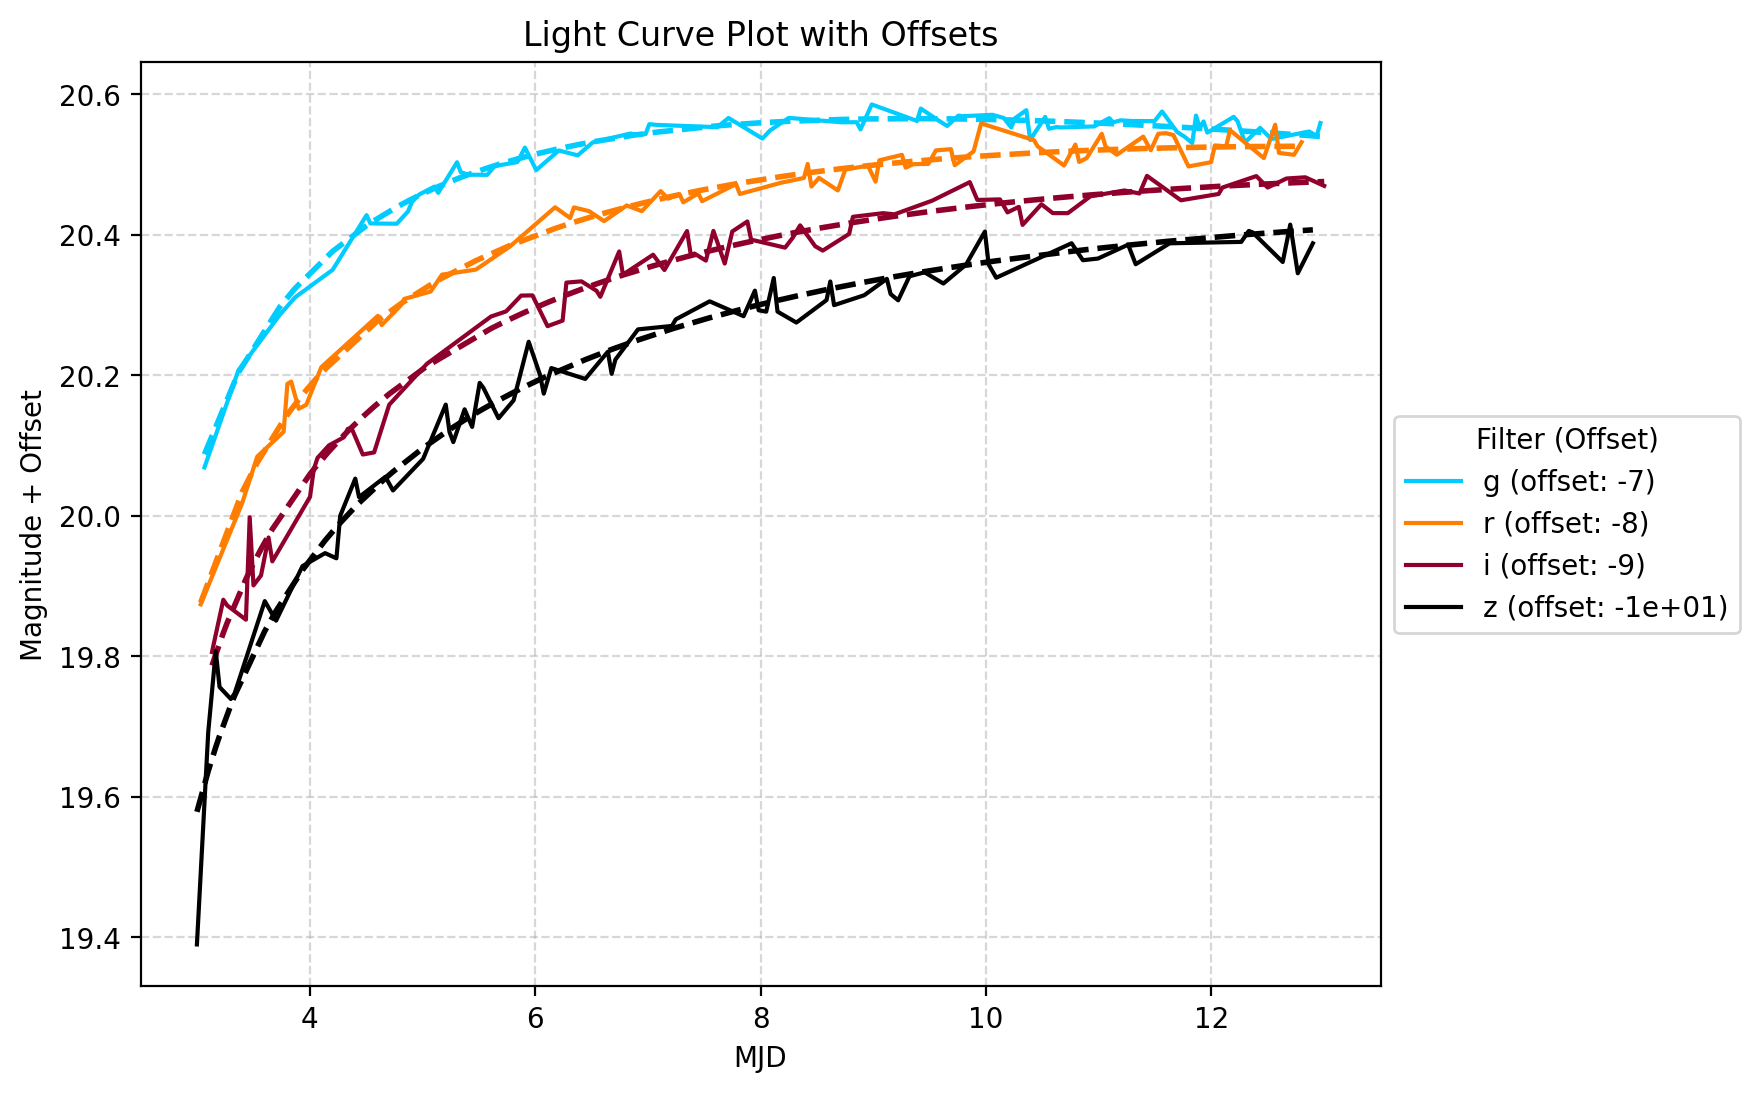

In [37]:
import utils.utils as ut
importlib.reload(ut)

        
# light_curve_plot(lc)
ut.pilca_light_curve_plot(lc, offset = 1, pilcas=pilcas, ufilters=np.unique(filter_for_mjd))

# BNN

IMPLEMENTAR ----->> ADAPTANDO AO MODELO, USAR Y_TRUE COMO A LOGLUM E O ERRO COMO SENDO O DESVVIO ENTRE AS LUMINOSIDADES DE CADA MODELO

samples = torch.stack([bnn() for _ in range(10)])

y_mean = samples.mean(0)

y_std  = samples.std(0).clamp(min=1e-6)


loss_data = ((y_true - y_mean)**2 / (2 * y_std**2)) + torch.log(y_std)

loss_data = loss_data.mean()

somar regularizador (ex: prior dos pesos ou física)

loss = loss_data + physics_penalty



In [38]:
importlib.reload(tp)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.ModifiedSC4Loss(sc4model, ufilters=ufilters)

## regular loss approach

In [39]:
importlib.reload(tp)

bnn = tp.MultiFilterBNN(x_data=X_DATA,
                    filters_mask=filters_mask,
                    param_dim=4,
                    hidden_dim=32)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1e-3
optimizer = torch.optim.Adam(bnn.parameters(), lr=lr)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.SC4Loss(sc4model, ufilters=ufilters)
epochs = 5000
n_samples_loss = 10


for epoch in range(epochs):
    optimizer.zero_grad()

    
    outputs = bnn()+1e-4#.get_params()
    # outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa
    loss = criterion(outputs.squeeze(), X_DATA, filters_mask)#/n_samples_loss

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        # with torch.no_grad():
        tp.print_outputs(outputs.squeeze(), loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


--- Step 0 ---
Shock velocity (v_s):     1.0246
Envelope mass (M_env):    1.6887
Density factor (f_rho_M): 1.6887
Radius (R):               4.5463
Explosion time (t_exp):   2.4434
Loss:                     0.073609
----------------------------------------
--- Step 1 ---
Shock velocity (v_s):     1.9068
Envelope mass (M_env):    1.9882
Density factor (f_rho_M): 1.9882
Radius (R):               9.1627
Explosion time (t_exp):   1.9426
Loss:                     1.053166
----------------------------------------
--- Step 2 ---
Shock velocity (v_s):     1.8203
Envelope mass (M_env):    1.8866
Density factor (f_rho_M): 1.8866
Radius (R):               3.8163
Explosion time (t_exp):   2.8742
Loss:                     0.168745
----------------------------------------
--- Step 3 ---
Shock velocity (v_s):     1.8096
Envelope mass (M_env):    1.9183
Density factor (f_rho_M): 1.9183
Radius (R):               4.5363
Explosion time (t_exp):   1.8698
Loss:                     0.378792
-----------------

KeyboardInterrupt: 

## modified loss approach

In [40]:
importlib.reload(tp)

bnn = tp.MultiFilterBNN(x_data=X_DATA,
                    filters_mask=filters_mask,
                    param_dim=4,
                    hidden_dim=32)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1e-3
optimizer = torch.optim.Adam(bnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.ModifiedSC4Loss(sc4model, ufilters=ufilters)
y_true = criterion.get_y_true(X_DATA, filters_mask)


epochs = 5000
n_samples_loss = 50

def hard_loss(y_pred, y_true):

    return torch.mean((y_pred - y_true)**2)
mae =  torch.nn.L1Loss()
# mse =  torch.nn.MSE()
for epoch in range(epochs):
    optimizer.zero_grad()

    
    # outputs = bnn()+1e-4#.get_params()
    # outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa]

    outputs_many = torch.stack([bnn().squeeze() for i in range(n_samples_loss)])
    outputs_mean = outputs_many.mean(0)

    y_many = torch.stack([criterion(outputs_many[i], X_DATA, filters_mask) for i in range(n_samples_loss)])
    y_mean = criterion(outputs_mean, X_DATA, filters_mask)#y_many.mean(0)#

    # y_std  = y_many.std(0).clamp(min=1e-6)


    loss_data = (y_true - y_mean)**2 / (2 * y_std**2) + torch.log(y_std)

    # loss = loss_data.mean() + criterion.get_penalty(outputs_mean)
    loss = torch.nn.functional.mse_loss(y_true, y_mean) + criterion.get_penalty(outputs_mean)

    # somar regularizador (ex: prior dos pesos ou física)

    # loss = loss_data + physics_penalty


    # y_fit = criterion(outputs.squeeze(), X_DATA, filters_mask)#/n_samples_loss

    

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 100 == 0:
        # with torch.no_grad():
        tp.print_outputs(outputs_mean, loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


--- Step 0 ---
Shock velocity (v_s):     2.2174
Envelope mass (M_env):    1.4215
Density factor (f_rho_M): 1.4215
Radius (R):               3.7365
Explosion time (t_exp):   3.8562
Loss:                     0.151833
----------------------------------------


--- Step 100 ---
Shock velocity (v_s):     1.3058
Envelope mass (M_env):    1.6800
Density factor (f_rho_M): 1.6800
Radius (R):               4.4983
Explosion time (t_exp):   2.2997
Loss:                     0.002220
----------------------------------------
--- Step 200 ---
Shock velocity (v_s):     1.4058
Envelope mass (M_env):    1.7189
Density factor (f_rho_M): 1.7189
Radius (R):               3.2692
Explosion time (t_exp):   2.2375
Loss:                     0.001681
----------------------------------------
--- Step 300 ---
Shock velocity (v_s):     1.3720
Envelope mass (M_env):    1.6520
Density factor (f_rho_M): 1.6520
Radius (R):               3.7417
Explosion time (t_exp):   2.3772
Loss:                     0.001042
----------------------------------------
--- Step 400 ---
Shock velocity (v_s):     1.3384
Envelope mass (M_env):    1.6018
Density factor (f_rho_M): 1.6018
Radius (R):               4.3125
Explosion time (t_exp):   2.1595
Loss:                     0.003290
---------

## evaluation

In [41]:
samples = []
for i in range(1000):
    samples.append(bnn())
samples = torch.stack(samples).detach().cpu().numpy() # shape [N_samples, 5]

print(samples.shape)


(1000, 4)


In [45]:
mean, model_inputs


(array([1.34047777, 1.60639424, 3.94900662, 2.50161533]),
 array([1.26491106, 2.        , 4.03506331, 2.5       ]))

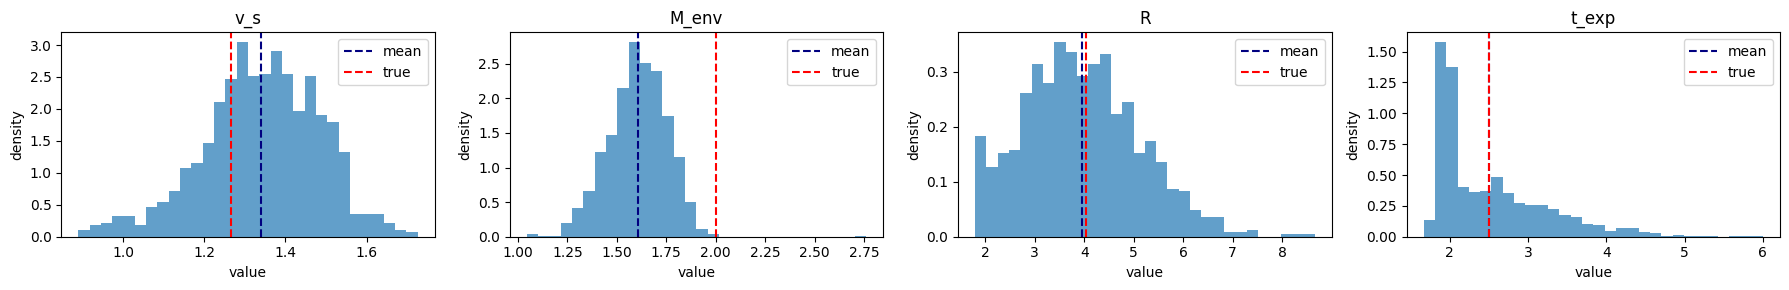

In [42]:

param_names = ["v_s", "M_env",  "R", "t_exp"]
mean = samples.mean(0)
std = samples.std(0)
true = model_inputs
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
for i, name in enumerate(param_names):
    axes[i].hist(samples[:, i], bins=30, density=True, color="tab:blue", alpha=0.7)
    axes[i].axvline(mean[i], color="navy", linestyle="--", label="mean")
    axes[i].axvline(true[i], color="red", linestyle="--", label="true")

    axes[i].set_title(name)
    axes[i].set_xlabel("value")
    axes[i].set_ylabel("density")
    axes[i].legend()

plt.tight_layout()
plt.show()

79 79 79
75 75 75
74 74 74
72 72 72
79 79 79
75 75 75
74 74 74
72 72 72


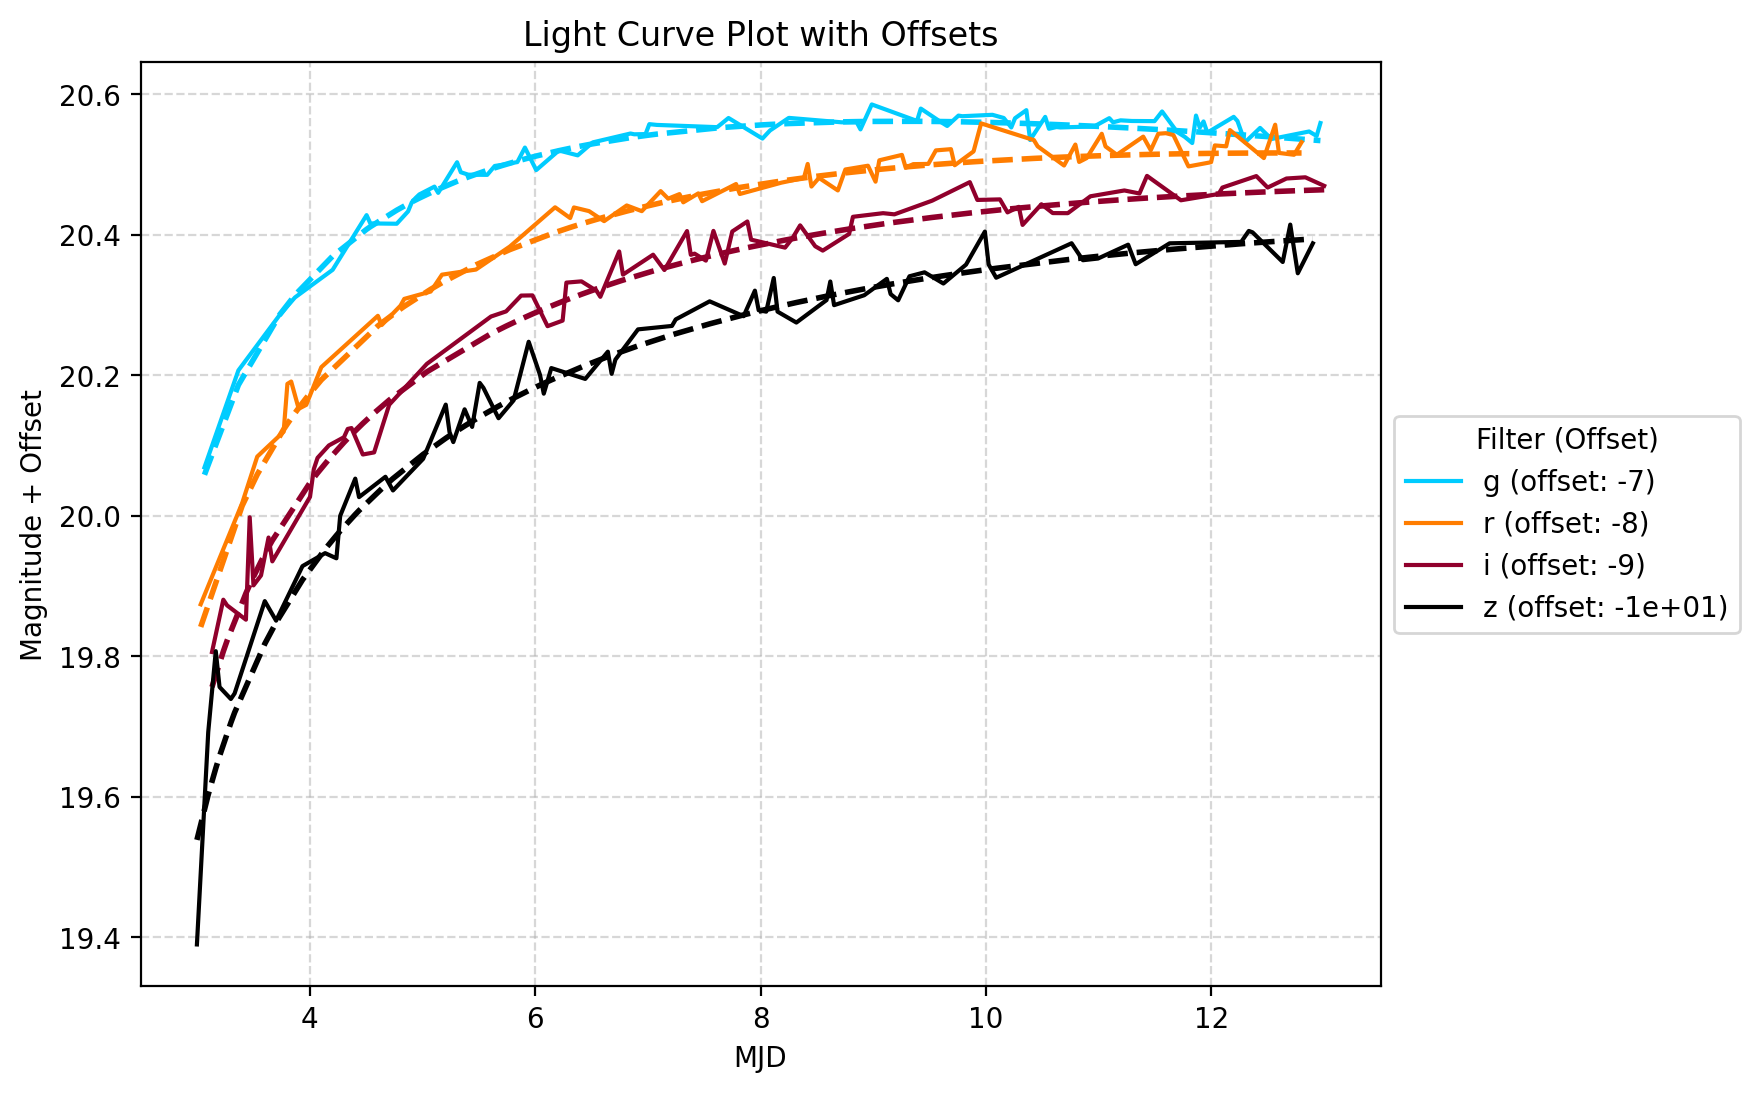

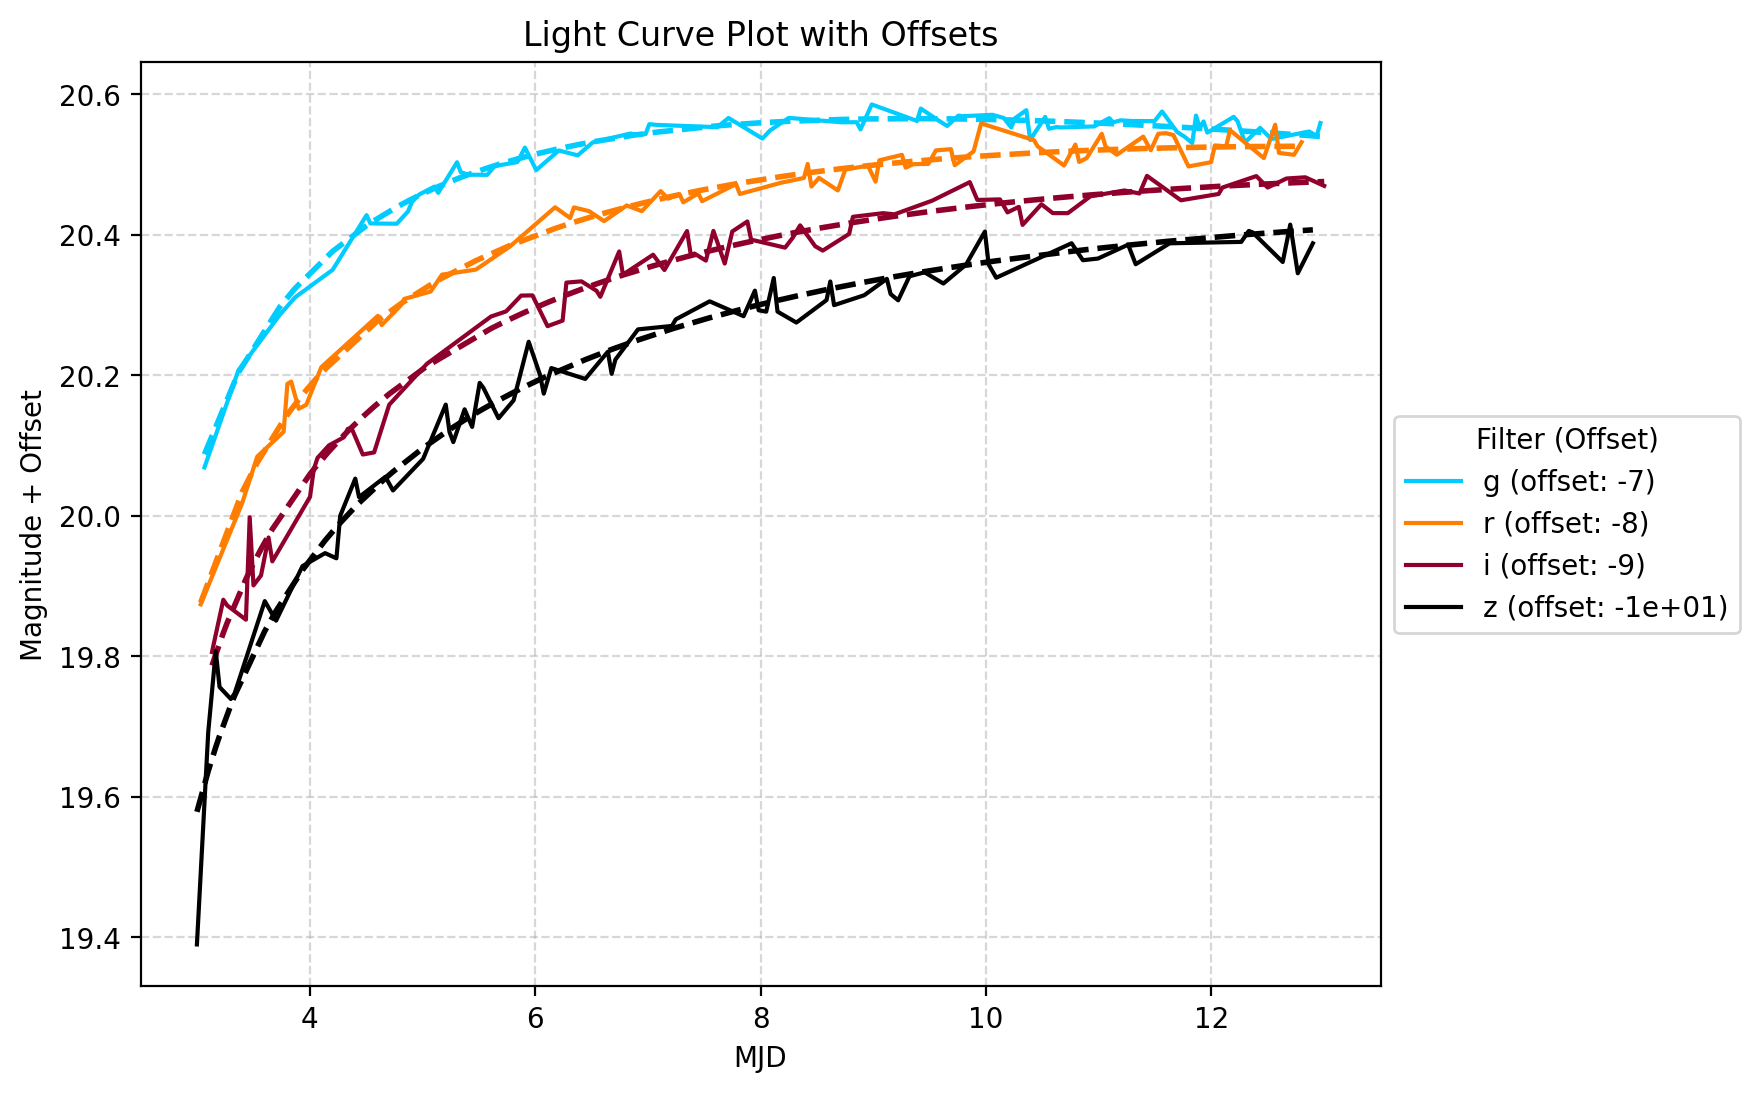

In [46]:
importlib.reload(ut)
ut.plot_comparison(lc,
                    outputs_mean, filter_for_mjd, MJD, filters_mask)
ut.plot_comparison(lc,
                    model_inputs_torch, filter_for_mjd, MJD, filters_mask)


In [ ]:
a

NameError: name 'a' is not defined

# MDN

In [ ]:
X_DATA.shape, filters_mask.shape

(torch.Size([300, 3]), torch.Size([5, 300]))

In [ ]:
importlib.reload(tp)

mdn = tp.MultiFilterMDN(x_data=X_DATA,
                    filters_mask=filters_mask,
                    param_dim=5,
                    num_components=3,
                    hidden_dim=32)

In [ ]:
mdn.get_params()[1].shape


mdn.get_params()



tensor([0.0629, 0.3767, 0.4119, 0.3053, 0.0922], grad_fn=<AddBackward0>)

In [ ]:
importlib.reload(tp)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1
optimizer = torch.optim.Adam(mdn.parameters(), lr=lr)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.SC4Loss(sc4model, ufilters=ufilters)
epochs = 20
n_samples_loss = 10

def hard_loss(y_pred, y_true):

    return torch.mean((y_pred - y_true)**2)

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mdn.get_params()
    # outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa
    loss = criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        # with torch.no_grad():
        tp.print_outputs(outputs.squeeze(), loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


ValueError: too many values to unpack (expected 4)

0

In [ ]:
for p in mdn.parameters(): 
    print(p.grad.abs().mean())

tensor(53.5003)
tensor(5.6190)
tensor(42.8264)
tensor(32.3367)
tensor(75.9660)
tensor(8.0848)
tensor(71.6435)
tensor(33.3304)
tensor(197.5081)
tensor(20.9123)
tensor(151.1851)
tensor(45.4060)
tensor(118.1536)
tensor(12.7837)
tensor(72.7717)
tensor(26.9660)
tensor(102.9334)
tensor(11.0119)
tensor(123.0183)
tensor(46.4581)
tensor(231.2423)
tensor(182.9379)
tensor(102.0486)
tensor(178.0926)
tensor(190.6379)
tensor(332.6963)


AttributeError: 'NoneType' object has no attribute 'abs'

# Normalizing Flows

In [ ]:
import torch
from nflows.transforms.base import Transform

class ExpTransform(Transform):
    """Bijetiva: ℝ → (0, ∞)"""
    def _call(self, inputs, context=None):
        return torch.exp(inputs)

    def _inverse(self, outputs, context=None):
        eps = 1e-10
        return torch.log(outputs + eps)

    def _log_det_jacobian(self, inputs, context=None):
        # log|dy/dx| = sum(log(exp(x))) = sum(x)
        return torch.sum(inputs, dim=1)


In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from nflows.flows import Flow
from nflows.transforms import MaskedAffineAutoregressiveTransform
from nflows.distributions import StandardNormal
torch.autograd.set_detect_anomaly(True)
from nflows.transforms import CompositeTransform, Sigmoid, AffineTransform, LeakyReLU, Tanh
from nflows.transforms.base import Transform

p_low, p_high = 0, 10
param_dim = 5
k_layers = 1

layers = []

for i in range(k_layers):
    layers+=[MaskedAffineAutoregressiveTransform(features=param_dim, hidden_features=32),
            # ExpTransform()#LeakyReLU(negative_slope=1e-3)
            # AffineTransform()
            ] 

flow = Flow(
    CompositeTransform(layers),
    StandardNormal([param_dim])
)
flow = flow.double()

In [ ]:
a = flow.sample(1)
a = tp.sigmoid(a, b=1e-3)
a = tp.denormalize(a, low=0, high=10)
a

tensor([[4.9946, 5.0082, 5.0061, 4.9998, 4.9970]], grad_fn=<AddBackward0>)

In [ ]:
importlib.reload(tp)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1e-1
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.SC4Loss(sc4model, ufilters=ufilters)
epochs = 3000
n_samples_loss = 10

def hard_loss(y_pred, y_true):

    return torch.mean((y_pred - y_true)**2)

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = flow.sample(num_samples=1)
    outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa
    loss = criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        with torch.no_grad():
            tp.print_outputs(outputs.squeeze(), loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


--- Step 0 ---
Shock velocity (v_s):     4.9955
Envelope mass (M_env):    4.9942
Density factor (f_rho_M): 4.9997
Radius (R):               5.0009
Explosion time (t_exp):   5.0041
Loss:                     0.849724
----------------------------------------


/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/us

RuntimeError: Function 'MulBackward0' returned nan values in its 0th output.

In [ ]:
print(model_inputs)

[1.26491106 2.         0.21       4.03506331 2.5       ]


In [ ]:
model_inputs_torch
a = torch.tensor([1.26491106, 2., 0.21, 4.03506331, 2.5]).to(torch.float64)

In [ ]:
a, model_inputs_torch

(tensor([1.2649, 2.0000, 0.2100, 4.0351, 2.5000]),
 tensor([1.2649, 2.0000, 0.2100, 4.0351, 2.5000]))

In [ ]:

model_inputs_torch = torch.tensor([1.26491106, 2., 0.21, 4.03506331, 2.5]).to(torch.float64)#outputs.squeeze()#torch.tensor([]])#/units_array

v_s = model_inputs_torch[0]       # Shock velocity
M_env = model_inputs_torch[1]     # Envelope mass
f_rho_M = model_inputs_torch[2]   # Density profile factor
R = model_inputs_torch[3]         # Radius
t_exp = model_inputs_torch[4]   # explosion time
model = tp.ShockCooling4(z=lc.meta["redshift"])
for f in np.unique(filter_for_mjd):
    mask = filter_for_mjd == f
    y = model(MJD[mask], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
    print(y)

##################################


tensor([2.0491e+20, 2.1171e+20, 2.2100e+20, 2.4110e+20, 2.4521e+20, 2.5720e+20,
        2.6810e+20, 2.6994e+20, 2.7895e+20, 2.7923e+20, 2.7948e+20, 2.7970e+20,
        2.8044e+20, 2.8057e+20, 2.8052e+20, 2.7746e+20, 2.7505e+20, 2.7427e+20,
        2.7215e+20, 2.7125e+20, 2.7078e+20, 2.6885e+20, 2.6414e+20, 2.6247e+20,
        2.6190e+20, 2.6025e+20, 2.5882e+20, 2.5314e+20, 2.4618e+20, 2.3144e+20,
        2.2756e+20, 2.2248e+20, 2.1507e+20, 2.1265e+20, 2.0907e+20, 2.0789e+20,
        2.0439e+20, 2.0323e+20, 1.9868e+20, 1.9645e+20, 1.9205e+20, 1.8253e+20,
        1.8150e+20, 1.7448e+20, 1.6494e+20, 1.6401e+20, 1.5859e+20, 1.5683e+20,
        1.4915e+20, 1.4109e+20, 1.3500e+20, 1.3352e+20, 1.2570e+20, 1.2501e+20,
        1.2433e+20, 1.2298e+20, 1.2165e+20, 1.1398e+20, 1.1095e+20, 1.0572e+20,
        1.0348e+20, 1.0130e+20, 1.0076e+20])
tensor([7.1684e+19, 7.4415e+19, 8.2378e+19, 9.2467e+19, 1.1735e+20, 1.2146e+20,
        1.3125e+20, 1.5831e+20, 1.6130e+20, 1.6420e+20, 1.6562e+20, 1.7376e